In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
pd.options.mode.chained_assignment = None  # default='warn'

In [47]:
df = pd.read_parquet("../data/ecomm_invoice_transaction.parquet")
sample = df.copy()

In [48]:
# drop anonymous user
anonymous_customer_index = sample[sample['CustomerID'] == 0].index
sample = sample.drop(index=anonymous_customer_index)

# RFM
freq = sample.groupby(['CustomerID'])['InvoiceNo'].nunique().reset_index().rename({'InvoiceNo': 'frequency'}, axis=1)
monetary = sample.groupby('CustomerID')["total_spend"].sum().reset_index().rename({'total_spend': 'monetary'}, axis=1)

# recency
unique_invoice = sample[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates(['InvoiceNo'])
unique_invoice['recency'] = unique_invoice.groupby('CustomerID')['InvoiceDate'].diff().dt.days
recency = unique_invoice.drop_duplicates("CustomerID", keep='last')

# NaN occured in recency for one time purchase (first time buyer)
calculation_date = unique_invoice["InvoiceDate"].max()
recency['recency'] = recency["recency"].fillna((calculation_date - unique_invoice["InvoiceDate"])) \
                                        .apply(lambda x: x if type(x) == float else x.days) \
                                        .astype(int)
recency = recency.drop(columns=['InvoiceNo', 'InvoiceDate'])

# create new feature `is_first_time_buyer`
recency.loc[recency['recency'].isnull(), 'is_first_time_buyer'] = int(1)
recency['is_first_time_buyer'] = recency['is_first_time_buyer'].fillna(0).astype(int)

# merge customer profiles
customer_profile = recency.merge(freq, on='CustomerID').merge(monetary, on='CustomerID')

(4372, 5)


,CustomerID,recency,is_first_time_buyer,frequency,monetary
0,18074,373,0,1,489.60
1,13747,373,0,1,79.60
2,12791,373,0,1,192.60
3,17908,373,0,1,243.28
4,16583,373,0,1,233.45


In [49]:
# More Feature Engineering to customer_profile
# 1. mean time between purchases
# 2. mean ticket size (AVG spent per trasaction)
# 3. mean total unique item per purchase
# 4. mean total quantity per purchase
# 5. mean spent per month
# 6. freq per month
# 7. refund times

# mean time interval between purchases
mean_time_interval = unique_invoice.groupby('CustomerID').agg({"recency": lambda x: x.diff().abs().mean()}).reset_index()
mean_time_interval = mean_time_interval.rename(columns={'recency': 'mean_time_interval'})
mean_time_interval['mean_time_interval'] = mean_time_interval['mean_time_interval'].apply(lambda x: round(x, 2))
mean_time_interval['mean_time_interval'] = mean_time_interval['mean_time_interval'].fillna(999)

# mean ticket_size, mean_qty, mean_unique_item
mean_per_purchase = sample.groupby(['CustomerID', 'InvoiceNo'])\
                              .agg({"total_spend": "sum", # aggregate some for each InvoiceNo and CustomerID
                                  "Quantity": "sum",
                                  "StockCode": "nunique"})\
                              .groupby('CustomerID')\
                              .agg({"total_spend": "mean", # aggregate mean for each CustomerID
                                  "Quantity": "mean",
                                  "StockCode": "mean"})\
                              .reset_index()\
                              .rename(columns={'total_spend': 'mean_ticket_size',
                                             "Quantity": "mean_quantity",
                                             "StockCode": "mean_unique_item"})\
                              .round(2)

# mean_spent_per_month, freq_per_month
per_period = sample[['CustomerID', 'InvoiceNo', 'StockCode', 'InvoiceDate', 'total_spend']]
per_period['month'] = per_period['InvoiceDate'].dt.month
# per_period['week'] = per_period['InvoiceDate'].dt.isocalendar().week

per_month = per_period.groupby(['CustomerID', 'month'])\
                        .agg({"InvoiceNo": "nunique", "total_spend": "mean"})\
                        .groupby(['CustomerID'])\
                        .agg({"InvoiceNo": "mean", "total_spend": "mean"})\
                        .round(2)\
                        .reset_index()\
                        .rename(columns={'InvoiceNo': 'freq_per_month', 'total_spend': 'mean_spent_per_month'})

# aggregate engineered features
rfm = customer_profile.merge(mean_time_interval, on='CustomerID')\
                        .merge(mean_per_purchase, on='CustomerID')\
                        .merge(per_month, on='CustomerID')

In [214]:
# print(rfm)
# print(rfm.shape)

KMeans

In [51]:
scaler = RobustScaler()
scaled_rfm = scaler.fit_transform(rfm.drop(columns=["CustomerID"]))
scaled_rfm = pd.DataFrame(scaled_rfm, columns=rfm.drop(columns=["CustomerID"]).columns)

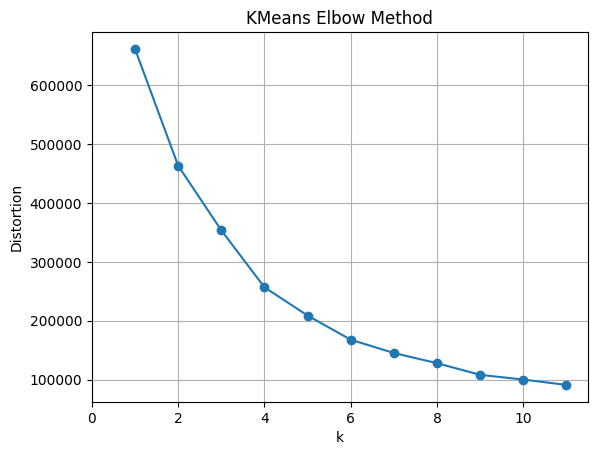

In [52]:
default_k = 3
feature_number = len(rfm.columns)
distortions = []

for k in range(1, feature_number+1):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init="auto",
        random_state=0
    )
    kmeans.fit(scaled_rfm)
    distortions.append(kmeans.inertia_)

In [53]:
# finding optimal k considered by distortions
def find_best_elbow(distortions: list) -> int:
    """
    Function to find an optimal k value
    """
    array_distortions = np.array(distortions)
    # 1st derivative: graph slope
    slopes = np.divide(array_distortions[1:], array_distortions[:-1])
    # 2nd derivative: rate of change
    slope_changes = np.diff(slopes)

    # tmp variables for the next process
    tmp_slopes = slopes.copy()
    tmp_slope_changes = slope_changes.copy()

    # find the most optimal k
    while True:
        # find the lowest slope change (the most linear index)
        min_slope_change_index = np.argmin(abs(tmp_slope_changes))

        # verifying if there's no lower slope after the most linear point
        if (tmp_slope_changes[min_slope_change_index] < tmp_slopes[min_slope_change_index:]).all():
            k_optimal = min_slope_change_index + 2
        else:
            tmp_slope_changes[min_slope_change_index] = 1
            continue
        return k_optimal

optimal_k = find_best_elbow(distortions=distortions)

In [215]:
# print(optimal_k)

In [55]:
# cluster
kmeans = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    n_init="auto",
    random_state=0
)
rfm["cluster"] = kmeans.fit(scaled_rfm).labels_

In [ ]:
"""
clusters profiling
1. cross-validate to find the best estimator to explain clustering
2. pemutation feature importance, to preserve interpretation of feature importance for each clustering
3. rank feature importance to dynamiacally give cluster behavior to each cluster
"""

Train model

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report #TODO: delete classification_report
from lightgbm import LGBMClassifier

In [57]:
X = rfm.drop(columns=["CustomerID", "cluster"])
y = rfm["cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [108]:
model = LGBMClassifier()
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.1, 0.3, 0.5],
    "max_depth": [6, 15],
    "num_leaves": [63, 255],
    "lambda_l1": [0.5, 1],
    "lambda_l2": [0, 0.5],
    "min_data_in_leaf": [20, 500],
    "max_bin": [127, 255],
    "feature_fraction": [1],
    "subsample": [0.5, 1]
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    cv=10,
    scoring="f1_macro",
    random_state=0
)
search.fit(X_train, y_train)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: f

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(),
                   param_distributions={'feature_fraction': [1],
                                        'lambda_l1': [0.5, 1],
                                        'lambda_l2': [0, 0.5],
                                        'learning_rate': [0.1, 0.3, 0.5],
                                        'max_bin': [127, 255],
                                        'max_depth': [6, 15],
                                        'min_data_in_leaf': [20, 500],
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_leaves': [63, 255],
                                        'subsample': [0.5, 1]},
                   random_state=0, scoring='f1_macro')

In [109]:
best_params = search.best_params_ # for tracking
# print(best_params)
tuned_model = search.best_estimator_
# print(tuned_model)

In [217]:
y_pred = tuned_model.predict(X_test)

In [219]:
# print(f1_score(y_true=y_test, y_pred=y_pred, average="macro"))

Permutation Feature Importance For entire dataset

In [100]:
result = permutation_importance(
    estimator=tuned_model, 
    X=X,
    y=y,
    scoring="f1_macro",
    n_repeats=5,
    random_state=0
)

In [132]:
sorted_importances_idx = result["importances_mean"].argsort()

In [135]:
X.columns[sorted_importances_idx][::-1]

Index(['monetary', 'mean_ticket_size', 'mean_spent_per_month',
       'mean_unique_item', 'frequency', 'mean_time_interval', 'mean_quantity',
       'freq_per_month', 'is_first_time_buyer', 'recency'],
      dtype='object')

In [136]:
result.get("importances_mean")[sorted_importances_idx][::-1]

array([0.38729492, 0.30486658, 0.17488148, 0.11661994, 0.06279831,
       0.05586081, 0.00537096, 0.        , 0.        , 0.        ])

Permutation Feature Importance For entire dataset

In [201]:
y_pred = model.predict(X_train)
cluster_results = {}
for target in y.unique():
    result = permutation_importance(
        estimator=tuned_model, 
        X=X[y == target],
        y=y[y == target],
        scoring="f1_macro",
        n_repeats=5,
        random_state=0
    )
    cluster_results[target] = result

In [262]:
mapped_cluster_factor = {}
for cluster, importance_score in cluster_results.items():
    # find top 5 important feature for each cluster considered by important score
    sorted_importances_idx = importance_score["importances_mean"].argsort()
    top_5_factor = list(X.columns[sorted_importances_idx][::-1][:5])
    feature_importance = np.round(importance_score["importances_mean"][sorted_importances_idx][::-1][:5], 4)
    mapped_cluster_factor[cluster] = {
        "columns": top_5_factor,
        "score": feature_importance
    }

define cluster behavior - post processing

In [263]:
# print(mapped_cluster_factor)
mapped_cluster_factor

{0: {'columns': ['mean_unique_item',
   'mean_spent_per_month',
   'freq_per_month',
   'mean_quantity',
   'mean_ticket_size'],
  'score': array([0.1, 0. , 0. , 0. , 0. ])},
 2: {'columns': ['monetary',
   'frequency',
   'freq_per_month',
   'mean_time_interval',
   'is_first_time_buyer'],
  'score': array([0.0213, 0.0034, 0.    , 0.    , 0.    ])},
 1: {'columns': ['mean_unique_item',
   'mean_ticket_size',
   'mean_spent_per_month',
   'freq_per_month',
   'mean_time_interval'],
  'score': array([0.0264, 0.0088, 0.    , 0.    , 0.    ])},
 3: {'columns': ['mean_spent_per_month',
   'freq_per_month',
   'mean_unique_item',
   'mean_quantity',
   'mean_ticket_size'],
  'score': array([0., 0., 0., 0., 0.])},
 4: {'columns': ['mean_quantity',
   'mean_ticket_size',
   'frequency',
   'mean_unique_item',
   'mean_spent_per_month'],
  'score': array([0.4444, 0.4444, 0.3333, 0.1111, 0.    ])}}

In [271]:
personalized_cluster_post_processing = {}
for cluster, detail in mapped_cluster_factor.items():
    if (detail["score"] == 0).sum() == 5: # top features
        continue
    else:
        # keep only matter features
        valid_features = (detail["score"] != 0).sum()
        detail["columns"] = detail["columns"][:valid_features]
        detail["score"] = detail["score"][:valid_features]

        personalized_cluster_post_processing[cluster] = detail

In [274]:
# print(personalized_cluster_post_processing)
personalized_cluster_post_processing

{0: {'columns': ['mean_unique_item'], 'score': array([0.1])},
 2: {'columns': ['monetary', 'frequency'], 'score': array([0.0213, 0.0034])},
 1: {'columns': ['mean_unique_item', 'mean_ticket_size'],
  'score': array([0.0264, 0.0088])},
 4: {'columns': ['mean_quantity',
   'mean_ticket_size',
   'frequency',
   'mean_unique_item'],
  'score': array([0.4444, 0.4444, 0.3333, 0.1111])}}

In [275]:
print("cluster behavior can't be identified")
missing_cluster = set(mapped_cluster_factor) - set(personalized_cluster_post_processing)
print(missing_cluster)
print({cluster: mapped_cluster_factor[cluster] for cluster in missing_cluster})

cluster behavior can't be identified
{3}
{3: {'columns': ['mean_spent_per_month', 'freq_per_month', 'mean_unique_item', 'mean_quantity', 'mean_ticket_size'], 'score': array([0., 0., 0., 0., 0.])}}


calculate promotion at a time

We need to exclude outlier, since we're gonna use all customer stats value for considering minimum spent, and promotion value

In [ ]:
# [frequency, monetary, mean_ticket_size]

first time

In [294]:
rfm_new = rfm.copy()

In [282]:
# if customer_id not exists in customer_profile -> return first_time promotion

for old customer

In [285]:
overall_clv = rfm["frequency"].mean()*rfm["monetary"].mean() # unit = currency
print(overall_clv)

In [295]:
rfm_new["current_clv"] = rfm["frequency"]*rfm["monetary"] # unit = currency

In [298]:
rfm_new["remaining_target_clv"] = ((rfm["frequency"]*rfm["monetary"]) - overall_clv).apply(lambda x: "{:f}".format(x))

In [280]:
rfm["mean_ticket_size"].mean() # minimum spend to claim a given promotion
# std -2, -1, 0, 1, 2 depends on customer frequency

315.8834103385178

In [308]:
rfm.describe(include="all")

,CustomerID,recency,is_first_time_buyer,frequency,monetary,mean_time_interval,mean_ticket_size,mean_quantity,mean_unique_item,freq_per_month,mean_spent_per_month,cluster
count,4372.000000,4372.000000,4372.0,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,87.124657,0.0,5.075480,1898.459701,513.749113,315.883410,196.806713,19.252683,1.387774,30.286921,0.022187
std,1722.390705,99.704745,0.0,9.338754,8219.345141,474.449265,361.237244,321.139564,17.278803,0.836526,135.581316,0.227812
min,12346.000000,0.000000,0.0,1.000000,-4287.630000,0.000000,-4287.630000,-244.000000,1.000000,1.000000,-4287.630000,0.000000
25%,13812.750000,12.000000,0.0,1.000000,293.362500,36.000000,151.990000,78.000000,8.000000,1.000000,10.137500,0.000000
50%,15300.500000,45.000000,0.0,3.000000,648.075000,190.500000,236.985000,137.000000,14.500000,1.000000,16.690000,0.000000
75%,16778.250000,131.000000,0.0,5.000000,1611.725000,999.000000,370.815000,232.207500,24.670000,1.500000,24.030000,0.000000
max,18287.000000,373.000000,0.0,248.000000,279489.020000,999.000000,6207.670000,12540.000000,219.000000,20.670000,3861.000000,4.000000


In [299]:
rfm_new["remaining_target_clv"] # if remaining_clv > 0 -> not provide promotion

0         -9145.994870
1         -9555.994870
2         -9442.994870
3         -9392.314870
4         -9402.144870
             ...      
4367     323183.815130
4368    1046046.755130
4369      63486.855130
4370     410764.405130
4371      -6184.354870
Name: remaining_target_clv, Length: 4372, dtype: object

In [ ]:
# rfm_new["available_promo_1"] = 
# rfm_new["available_promo_2"] = 
# rfm_new["available_promo_3"] = 